In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, opening, area_closing)
from skimage.transform import resize
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd

Image Read and Denoise

In [2]:
def read_image(path):
    image = imread(path)
    if len(image.shape) > 2:
        return rgb2gray(image)
    return image

def bilateral_filter(image, diameter=15, sigma_color=75, sigma_space=75):
    print(image.max())
    if image.max() != 255:
        image = image * 255
        image = image.astype('uint8')
        return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space) / 255
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

def median_filter(image, kernel_size=3):
    if image.max() != 255:
        image = image * 255
        image = image.astype('uint8')
        return cv2.medianBlur(image, kernel_size) / 255
    return cv2.medianBlur(image, kernel_size)


def non_local_mean_filter(image, h=3):
    if image.max() != 255:
        image = image * 255
        image = image.astype('uint8')
        return cv2.fastNlMeansDenoising(image, h=h) / 255
    return cv2.fastNlMeansDenoising(image, h=h)

## Image thresholding and connected components

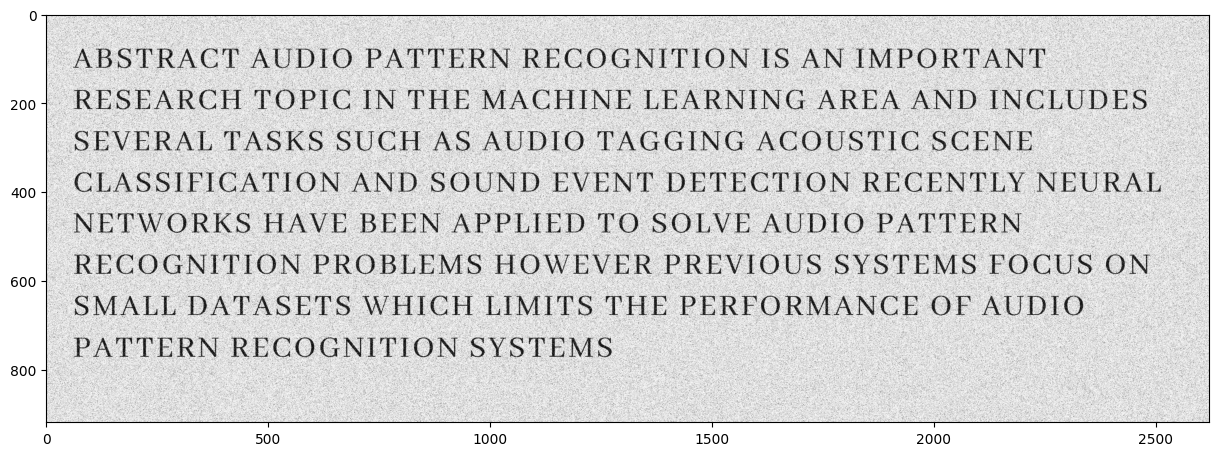

<Figure size 640x480 with 0 Axes>

In [93]:
image_path = "../Data/test_images/noisy_three_sentences.jpg"
image = read_image(image_path)
plt.figure(figsize=(15,15))
plt.imshow(image,cmap="gray")
plt.show()
plt.clf()


In [4]:
# plt.imshow(filtered_image_3, cmap="gray")
# plt.imshow(filtered_image_2, cmap="gray")

1.0


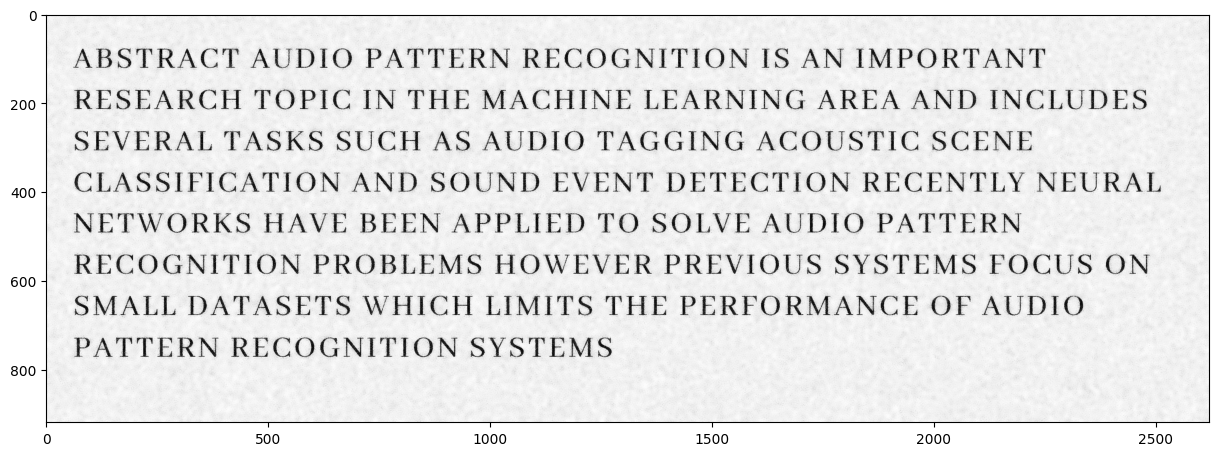

<Figure size 640x480 with 0 Axes>

In [121]:
filtered_image = bilateral_filter(image)
plt.figure(figsize=(15,15))
plt.imshow(filtered_image, cmap="gray")
plt.show()
plt.clf()

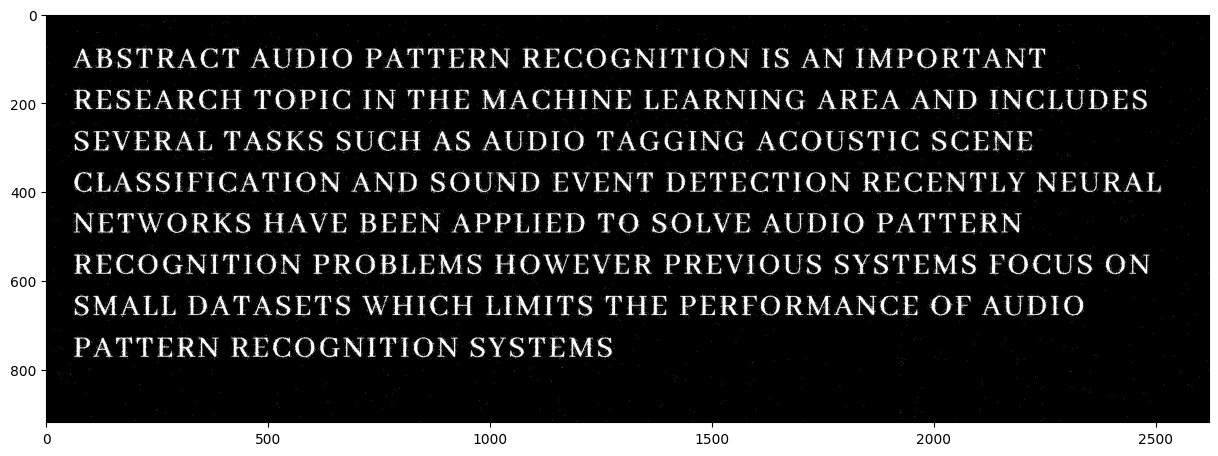

<Figure size 640x480 with 0 Axes>

In [155]:
binarized_image = filtered_image < 0.75
# binarized_image = non_local_mean_filter(binarized_image.copy())
plt.figure(figsize=(15,15))
plt.imshow(binarized_image, cmap="gray")
plt.show()
plt.clf()

## Erosion, Dilation

In [156]:
square = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]])
                   
def multi_dil(im, num, element=square):
    for i in range(num):
        im = dilation(im, element)
    return im
def multi_ero(im, num, element=square):
    for i in range(num):
        im = erosion(im, element)
    return im

In [157]:
def erosion_dilation(image, plot=False):
    multi_dilated = multi_dil(image, 7)
    area_closed = area_closing(multi_dilated, 5)
    multi_eroded = multi_ero(area_closed, 11)
    opened_image = opening(multi_eroded)
    if plot:
        plt.imshow(opened_image, cmap="gray")
    return opened_image

## Connected components

9241


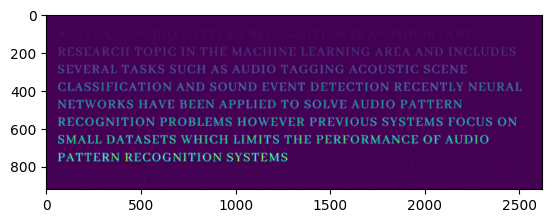

In [158]:
label_im = label(binarized_image)
regions = regionprops(label_im)
# regions = sorted(regions, key=lambda r: r.bbox[1])
print(len(regions))
plt.imshow(label_im)

In [159]:
# for lbl in np.unique(label_im):
#      # 0 would always be background
#      # print(lbl)
#      plt.imshow(label_im == lbl)
#      plt.show()

In [160]:
properties = ['area','convex_area','bbox_area', 'extent',  
              'mean_intensity', 'solidity', 'eccentricity', 
              'orientation', 'centroid', 'bbox']
pd.DataFrame(regionprops_table(label_im, filtered_image, 
             properties=properties))

,area,convex_area,bbox_area,extent,mean_intensity,solidity,eccentricity,orientation,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3
0,2,2,4,0.5,0.711765,1.0,1.0,-0.785398,0.5,474.5,0,474,2,476
1,1,1,1,1.0,0.713725,1.0,0.0,0.785398,1.0,1587.0,1,1587,2,1588
2,1,1,1,1.0,0.701961,1.0,0.0,0.785398,1.0,1981.0,1,1981,2,1982
3,1,1,1,1.0,0.721569,1.0,0.0,0.785398,1.0,2479.0,1,2479,2,2480
4,1,1,1,1.0,0.737255,1.0,0.0,0.785398,2.0,283.0,2,283,3,284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9236,1,1,1,1.0,0.690196,1.0,0.0,0.785398,916.0,2242.0,916,2242,917,2243
9237,1,1,1,1.0,0.733333,1.0,0.0,0.785398,917.0,1457.0,917,1457,918,1458
9238,1,1,1,1.0,0.733333,1.0,0.0,0.785398,918.0,842.0,918,842,919,843
9239,1,1,1,1.0,0.705882,1.0,0.0,0.785398,918.0,1196.0,918,1196,919,1197


In [161]:
masks = []
bbox = []
list_of_index = []
remove_nums = []
for num, x in enumerate(regions):
    area = x.area
    convex_area = x.convex_area
    
    if (convex_area/area > 0.95)  and area>200:
        print(num, area, convex_area, x.bbox, x.centroid)
        masks.append(regions[num].convex_image)
        bbox.append(regions[num].bbox)   
        list_of_index.append(num)
    else:
        # print(num)
        remove_nums.append(num)
for i in sorted(remove_nums, reverse=True):
    del regions[i]
count = len(masks)
print(count, len(regions))

166 610 1620 (75, 1485, 122, 1528) (98.96229508196721, 1506.4098360655737)
180 701 1483 (76, 113, 121, 149) (98.93437945791726, 130.53067047075606)
182 545 1324 (76, 160, 123, 192) (99.30825688073395, 176.1908256880734)
185 497 1385 (76, 203, 123, 240) (94.33802816901408, 220.9235412474849)
188 484 1549 (76, 347, 122, 387) (98.96487603305785, 364.2706611570248)
189 519 1401 (76, 397, 123, 435) (94.10982658959537, 415.6608863198459)
198 509 1539 (76, 906, 122, 941) (99.19056974459725, 922.1925343811395)
210 560 1339 (76, 1642, 123, 1674) (99.30357142857143, 1657.1875)
214 492 1378 (76, 2065, 122, 2104) (94.51626016260163, 2084.032520325203)
216 498 1371 (76, 2215, 122, 2251) (94.17469879518072, 2232.475903614458)
220 708 1675 (77, 250, 123, 291) (99.19350282485875, 268.1553672316384)
222 478 1099 (77, 461, 122, 505) (102.23012552301255, 483.9623430962343)
223 497 1651 (77, 511, 123, 555) (98.28772635814889, 528.9275653923542)
224 654 1756 (77, 562, 123, 605) (98.83792048929664, 582.9678

In [174]:
def find_space_indexes(regions):
    diff_xs = []
    for index, _ in enumerate(regions):
        if index != 0:
            diff_xs.append((regions[index].bbox[1] - regions[index-1].bbox[3]))
        else:
            diff_xs.append(-1)
    max_diff = sorted(diff_xs)[int(len(diff_xs)*0.90)]
    indexes= [1 if diff_xs[index] >= max_diff else 0 for index, _ in enumerate(regions)]
    print("index values", diff_xs, indexes, max_diff, len(diff_xs), len(indexes))
    return indexes

In [175]:
def re_arrange_letters(bbox, regions, limit=25):
    bbox = sorted(bbox, key=lambda x: x[0])
    regions = sorted(regions, key=lambda r: r.bbox[0])
    x_mins = list([str(box[0]) for box in bbox])
    print(x_mins)
    for x_min in x_mins:
        for i in range(1,limit):
            if str(int(x_min)+i) in x_mins:
                # print(str(int(x_min)+i), x_min)
                for k in range(len(x_mins)):
                    if x_mins[k] == str(int(x_min)+i):
                        x_mins[k] = x_min
                # x_mins = list(map(lambda x: x.replace(str(int(x_min)+i), x_min), x_mins))
    print(x_mins)
    x_mins = [int(x_min) for x_min in x_mins]
    for x_min, box in zip(x_mins, bbox):
        box = (x_min, box[1], box[2], box[3])
    x_mins.append(max(x_mins) + 1)
    unique_x_mins = sorted(list(set(x_mins)))
    print("Unique:", unique_x_mins)
    line_bbox, line_regions = [], []
    for index, unique_x_min in enumerate(unique_x_mins):
        if index==0:
            start = x_mins.index(unique_x_min)
            continue
        end = x_mins.index(unique_x_min)
        print(x_mins[start:end])
        line_bbox.append(bbox[start:end])
        line_regions.append(regions[start:end])
        # print(regions[start:end], bbox[start:end])
        start = end
    # print(line_regions)
    new_bbox, new_masks, new_regions, space_indexes, line_end_indexes = [], [], [], [], []
    for line_box, line_region in zip(line_bbox, line_regions):
        # print("Before")
        # [print(r.bbox) for r in line_region]
        line_region = sorted(line_region, key=lambda r: r.bbox[1])
        line_space_indexes = find_space_indexes(regions=line_region)
        space_indexes.extend(line_space_indexes)
        if len(line_end_indexes):
            line_end_indexes.append(line_end_indexes[-1] + len(line_space_indexes))
        else:
            line_end_indexes.append(len(line_space_indexes))
        # print("After")
        # [print(r.bbox) for r in line_region]
        line_box = sorted(line_box, key=lambda x: x[1])
        # print(line_box)
        new_mask = [region.convex_image for region in line_region]
        new_masks.extend(new_mask)
        new_bbox.extend(line_box)
        new_regions.extend(line_region)
    return new_bbox, new_masks, new_regions, space_indexes, line_end_indexes


['75', '76', '76', '76', '76', '76', '76', '76', '76', '76', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '78', '78', '78', '78', '78', '78', '78', '78', '78', '78', '78', '169', '169', '169', '169', '169', '169', '169', '169', '169', '169', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '171', '171', '171', '171', '171', '171', '171', '171', '171', '171', '171', '171', '172', '261', '261', '262', '262', '262', '262', '262', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '264', '264', '264', '264', '264', '264', '264', '264', '264', '264', '264', '264', '264', '354', '354', '355', '355', '355', '355', '355', '355', '355', '356', '356', '356', '356', '356', 

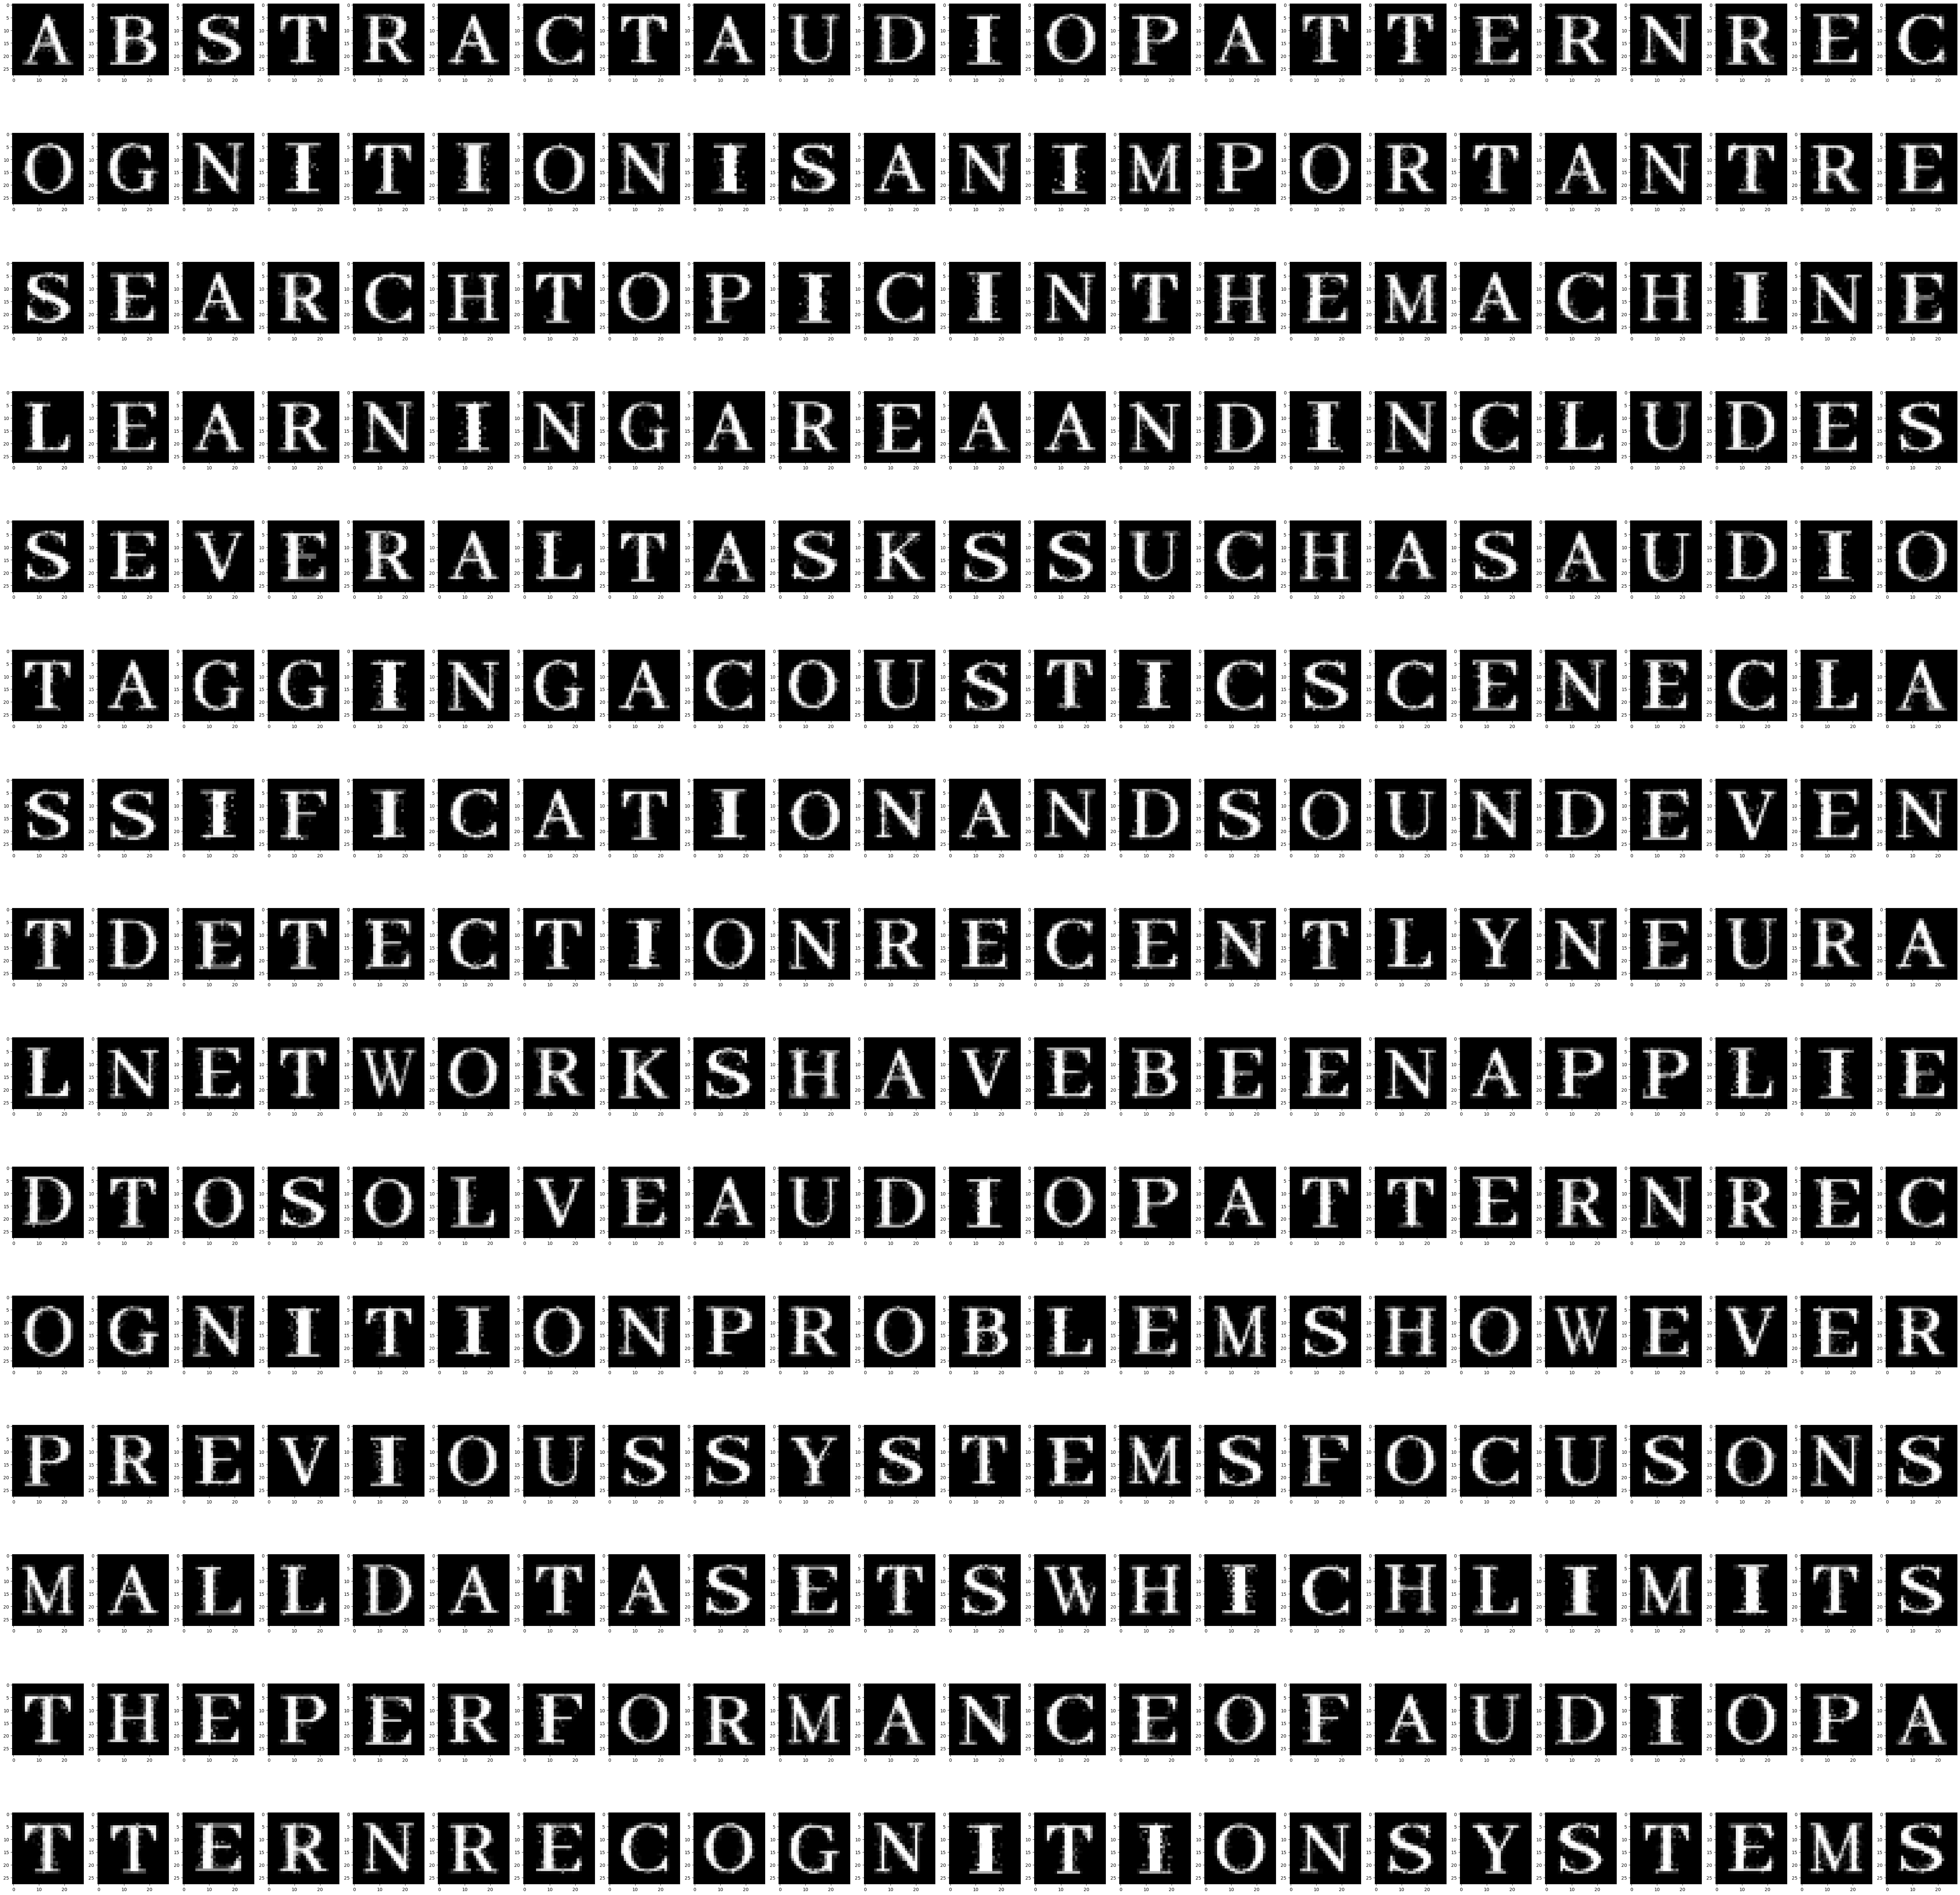

In [176]:
fig, ax = plt.subplots(15, int(count/15), figsize=(60,60))
bounded_images = []
bbox, masks, regions, space_indexes, line_end_indexes = re_arrange_letters(bbox, regions)
print(len(masks), line_end_indexes)
for index, (axis, box, mask) in enumerate(zip(ax.flatten(), bbox, masks)):
    bounded_image  =  binarized_image[box[0]:box[2], box[1]:box[3]] * mask
    bounded_image = np.pad(bounded_image, pad_width=10)
    bounded_image = bilateral_filter(bounded_image, 1)
    bounded_image = resize(bounded_image, (28, 28))
    # plt.imshow(bounded_image)
    # plt.savefig(f"../Data/test_images/msg_from_annie_{index}.png")
    bounded_images.append(bounded_image)
    axis.imshow(bounded_image, cmap="gray")
fig.tight_layout()


## Model Predict

In [177]:
from predict import CharacterPredictor

predictor = CharacterPredictor(model_path="../Data/model.pth")
output_filename = image_path.replace(".jpg", "_predicted.txt")
output_filename_with_spaces = image_path.replace(".jpg", "_predicted_with_spaces.txt")
output_file = open(output_filename, "w")
output_file_with_spaces = open(output_filename_with_spaces, "w")
for index, bounded_image in enumerate(bounded_images):
    prediction = predictor.predict(bounded_image)
    print(prediction)
    output_file.write(prediction)
    output_file_with_spaces.write(prediction)
    if index+1 < len(bounded_images):
        if space_indexes[index+1] == 1 or index+1 in line_end_indexes:
            output_file_with_spaces.write(" ")
output_file.close()
output_file_with_spaces.close()

A
B
S
R
K
A
C
R
A
U
U
I
O
P
A
T
T
E
R
N
R
L
C
O
C
N
I
R
X
O
N
X
S
A
N
I
M
P
O
R
R
A
N
R
R
E
S
E
A
R
C
H
T
O
P
X
C
I
N
R
U
E
M
A
C
H
I
N
B
N
E
A
R
N
I
N
C
D
R
E
A
A
N
D
I
N
C
L
U
D
L
S
S
L
V
E
R
A
L
T
A
S
K
S
S
U
C
H
A
S
A
U
D
I
O
R
A
C
G
X
N
G
A
C
O
U
S
T
I
C
S
C
H
N
L
C
L
A
S
S
I
R
X
C
A
T
I
O
N
A
N
D
S
O
U
N
D
E
V
E
N
T
D
E
R
L
C
T
X
O
N
R
E
C
E
N
R
L
Y
N
E
U
K
A
L
N
L
R
W
O
R
K
S
H
A
V
E
B
E
E
N
A
P
P
L
I
R
D
T
O
S
O
L
V
E
A
U
D
I
O
P
A
R
R
L
K
N
K
E
C
O
G
N
X
T
I
O
N
P
R
O
B
X
L
M
S
H
O
W
E
V
B
R
P
R
E
V
I
O
U
S
S
Y
S
R
E
M
S
R
O
C
U
S
O
N
S
M
A
L
N
U
A
R
D
S
E
R
S
W
H
I
C
H
L
X
M
I
R
S
R
H
L
P
B
K
R
O
R
M
A
N
C
E
O
R
A
U
D
I
O
P
A
R
T
L
R
N
R
E
C
O
C
N
X
R
I
O
N
S
Y
S
T
E
M
S


In [166]:
def compare_with_gt(gt_filename, predicted_filename):
    print(gt_filename)
    gt_file = open(gt_filename, "r")
    predicted_file = open(predicted_filename, "r")
    gt_line = gt_file.readline().strip()
    print(gt_line)
    predicted_line = predicted_file.readline().strip()
    count = 0
    for gt, predicted in zip(gt_line, predicted_line):
        print(gt, predicted)
        if predicted == gt.upper():
            count+=1
    gt_file.close()
    predicted_file.close()
    return count/len(gt_line)

In [167]:
compare_with_gt(gt_filename="/home/sci/zahid.aziz/Desktop/Projects/CS-6640-Image-Processing/project_5/Data/test_images/three_sentences_gt.txt", 
                predicted_filename= output_filename)

/home/sci/zahid.aziz/Desktop/Projects/CS-6640-Image-Processing/project_5/Data/test_images/three_sentences_gt.txt
AbstractAudiopatternrecognitionisanimportantresearchtopicinthemachinelearningareaandincludesseveraltaskssuchasaudiotaggingacousticsceneclassificationandsoundeventdetectionRecentlyneuralnetworkshavebeenappliedtosolveaudiopatternrecognitionproblemsHoweverprevioussystemsfocusonsmalldatasetswhichlimitstheperformanceofaudiopatternrecognitionsystems
A A
b B
s S
t R
r K
a A
c C
t R
A A
u U
d U
i I
o O
p P
a A
t T
t T
e E
r R
n N
r R
e L
c C
o O
g C
n N
i I
t R
i X
o O
n N
i X
s S
a A
n N
i I
m M
p P
o O
r R
t R
a A
n N
t R
r R
e E
s S
e E
a A
r R
c C
h H
t T
o O
p P
i X
c C
i I
n N
t R
h U
e E
m M
a A
c C
h H
i I
n N
e B
l N
e E
a A
r R
n N
i I
n N
g C
a D
r R
e E
a A
a A
n N
d D
i I
n N
c C
l L
u U
d D
e L
s S
s S
e L
v V
e E
r R
a A
l L
t T
a A
s S
k K
s S
s S
u U
c C
h H
a A
s S
a A
u U
d D
i I
o O
t R
a A
g C
g G
i X
n N
g G
a A
c C
o O
u U
s S
t T
i I
c C
s S
c C
e H
n N
e L
c

0.8144927536231884